<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install -U scikit-learn -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
import pandas as pd
import numpy as np
from numpy import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import lightgbm as lgm

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

In [3]:
pip install category_encoders -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [4]:
RANDOM_STATE = 42
VALID_SIZE = 0.1

In [5]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

## Подготовка

In [6]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [7]:
data.sort_index(inplace=True)

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [10]:
data = data.resample('1H').sum()

In [11]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Анализ

In [12]:
decomposed = seasonal_decompose(data)

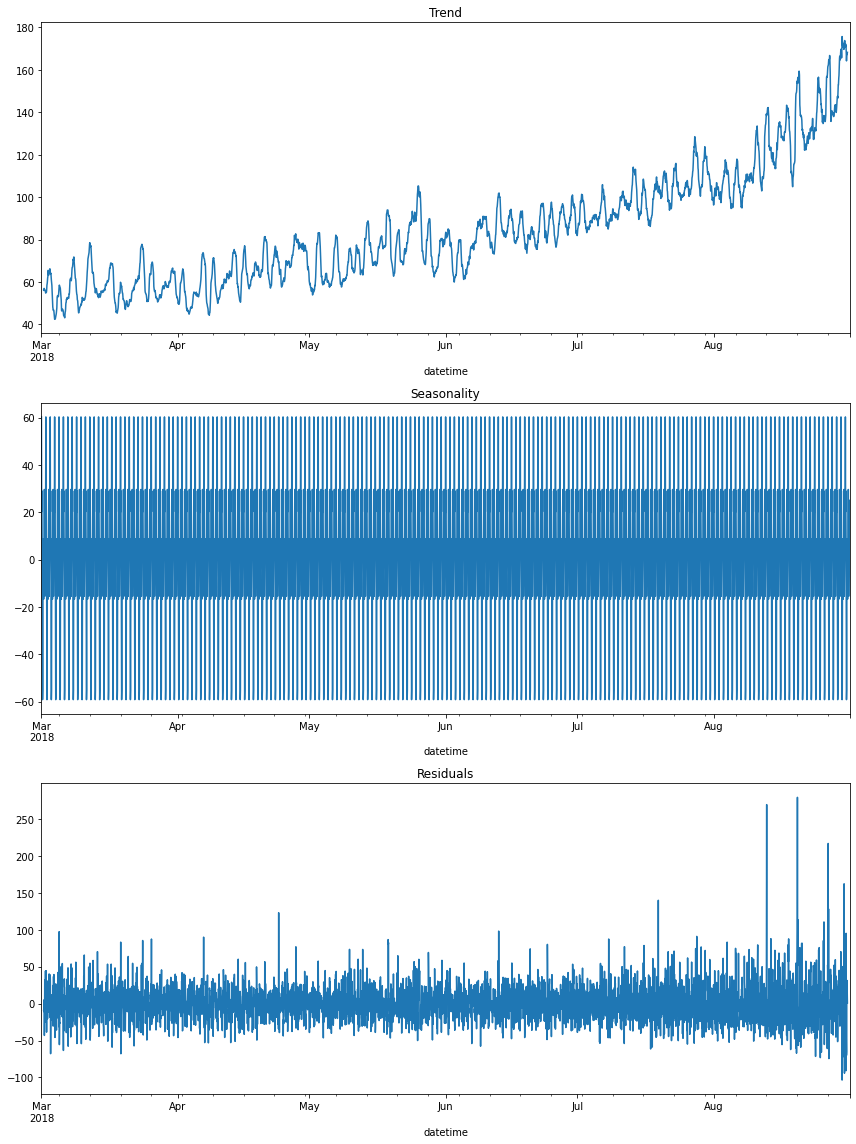

In [13]:
plt.figure(figsize=(12, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

**Общая тенденция по месяцам -** количество заказов такси увеличивается. Особенно это заметно в летние месяцы

In [14]:
seasonal = decomposed.seasonal

In [15]:
start_day = seasonal.index[0]
end_day = seasonal.index[47]

In [16]:
seasonal_cut = seasonal.loc[start_day:end_day]

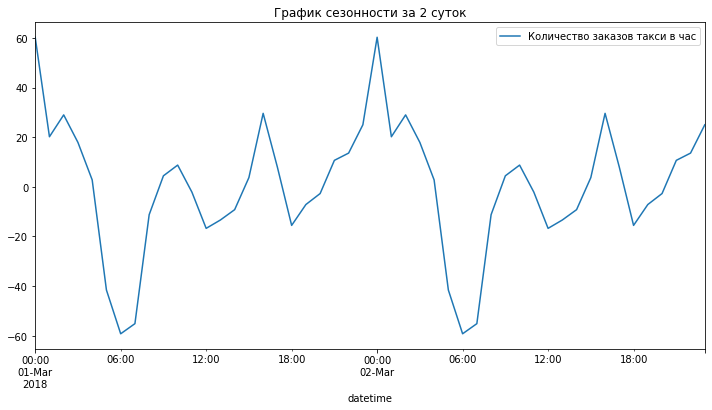

In [17]:
plt.figure(figsize=(12, 6))
seasonal_cut.plot(label='Количество заказов такси в час')
plt.legend()
plt.title('График сезонности за 2 суток')
plt.show()

**Сезонный график демонстрирует,** что ночное время это пик заказов такси. Падает к 6 утра, возрастает до средних значений к обеду и снова расте к полуночи 

## Обучение

In [18]:
make_features(data, 24, 24)

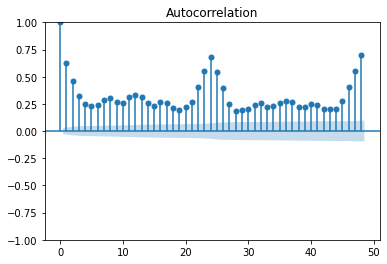

In [19]:
fig = plot_acf(data['num_orders'], lags=48)
plt.show()

In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [21]:
train = train.dropna()

In [22]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

In [23]:
X_test = test.drop('num_orders', axis=1)

In [24]:
y_test = test['num_orders']

**--------------------------------------------------------**

**Собираем пайп без бустинга**

In [25]:
num_col = X_train.drop('dayofweek', axis=1).columns

In [26]:
num_col

Index(['hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
       'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21',
       'lag_22', 'lag_23', 'lag_24', 'rolling_mean'],
      dtype='object')

In [27]:
ohe_col = ['dayofweek']

In [28]:
tscv = TimeSeriesSplit(n_splits=2)

In [29]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

In [30]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'num', StandardScaler()
        )
    ]
)

In [31]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder='passthrough'
)

In [32]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [33]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     {
        'models': [DecisionTreeRegressor()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [34]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=tscv,
    scoring = 'neg_root_mean_squared_error',  
    n_jobs=-1,
    verbose=0
)

In [35]:
grid_search.fit(X_train,y_train);

In [36]:
score = grid_search.cv_results_['mean_test_score'].min()

In [37]:
score_no_boost = abs(score)

In [38]:
print(f'Метрика RMSE для лучшей модели без градиентного бустинга на кроссвалидации равна {score_no_boost}')

Метрика RMSE для лучшей модели без градиентного бустинга на кроссвалидации равна 37.00461323626009


**Собираем пайп с бустингом**

In [39]:
X_train['dayofweek'] = X_train['dayofweek'].astype('category')
X_test['dayofweek'] = X_test['dayofweek'].astype('category')

In [40]:
param_grid_gbm = {
 'learning_rate': [0.1, 0.05],
 'n_estimators': [150 ,100],
 'max_depth': [5,7],
 'num_leaves':[3,5,7]
}

In [41]:
model_gbm = lgm.LGBMRegressor(objective='regression', random_state=RANDOM_STATE)

In [42]:
grid_search_gbm = GridSearchCV(
    model_gbm, 
    param_grid_gbm,
    cv=tscv,
    scoring = 'neg_root_mean_squared_error',  
    n_jobs=-1,
    verbose=2
)

In [43]:
grid_search_gbm.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=3; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=3; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=5; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=5; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=7; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=150, num_leaves=7; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=3; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=3; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=5; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=5; total time=   0.4s
[CV] END learning_r

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LGBMRegressor(objective='regression', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [5, 7],
                         'n_estimators': [150, 100], 'num_leaves': [3, 5, 7]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [44]:
score_gbm = grid_search_gbm.cv_results_['mean_test_score'].min()

In [45]:
score_boost = abs(score_gbm)

In [46]:
print(f'Метрика RMSE для лучшей модели c градиентным бустингом на кроссвалидации равна {score_boost}')

Метрика RMSE для лучшей модели c градиентным бустингом на кроссвалидации равна 29.821016556393893


**Модель с бустингом показала лучшие результаты на кросс валидации, выбираем ее для тестирования**

## Тестирование

In [47]:
pred_median = np.ones(y_test.shape) * train['num_orders'].median()

In [48]:
print(f'RMSE при прогнозе константой: {sqrt(mean_squared_error(y_test, pred_median))}')

RMSE при прогнозе константой: 87.15277582981295


In [49]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]

In [50]:
print(f'RMSE при прогнозе сдвигом: {sqrt(mean_squared_error(y_test, pred_previous))}')

RMSE при прогнозе сдвигом: 58.856486242815066


In [51]:
pred_boost = grid_search_gbm.best_estimator_.predict(X_test)

In [52]:
rmse_boost = sqrt(mean_squared_error(y_test, pred_boost))

In [53]:
print(f'RMSE при прогнозе моделью линейной регрессии: {rmse_boost}')

RMSE при прогнозе моделью линейной регрессии: 42.24746502847167


### Вывод:

**Модель градиентного бустинга оказалась более точной, чем предсказание константой или сдвигом, следовательно затраты на анализ данных и разработку модели имели смысл**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Данные загружены и подготовлены
- [X]  Данные проанализированы
- [X]  Модель обучена, гиперпараметры подобраны
- [X]  Качество моделей проверено, выводы сделаны
- [X]  Значение *RMSE* на тестовой выборке не больше 48